In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [111]:
df = pd.read_csv('household_power.csv')
df.drop(columns=["Day_Before_Holiday", "Day_After_Holiday"], inplace=True)
df

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Temperature_C,...,solar_radiation,Season,is_Day_Before_Holiday,is_Day_After_Holiday,Heures_Creuses,Tariff_Zone,Non_Submetered_Energy,Temp_Regime,Power_Factor,HICP_Energy_Index
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,19.0,607.0,626.0,7.0,...,0.0,Winter,0,0,0,Peak_Price,3596.888889,Cold_Heating,0.998533,73.35
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1415.0,6.9,...,0.0,Winter,0,0,0,Peak_Price,2217.200000,Cold_Heating,0.999757,73.35
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1087.0,6.4,...,0.0,Winter,0,0,0,Peak_Price,2313.233333,Cold_Heating,0.999686,73.35
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1007.0,6.0,...,0.0,Winter,0,0,0,Peak_Price,2261.566667,Cold_Heating,0.999736,73.35
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1058.0,5.6,...,0.0,Winter,0,0,0,Peak_Price,1998.466667,Cold_Heating,0.999686,73.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,2010-11-26 17:00:00,1.717448,0.063517,237.080345,7.182759,0.0,0.0,738.0,738.0,0.7,...,0.0,Autumn,0,0,0,Peak_Price,979.448276,Cold_Heating,0.999317,84.54
34585,2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.0,0.0,0.0,0.9,...,0.0,Autumn,0,0,0,Peak_Price,1573.466667,Cold_Heating,0.999418,84.54
34586,2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,4.0,0.0,4.0,0.6,...,0.0,Autumn,0,0,0,Peak_Price,1655.333333,Cold_Heating,0.999346,84.54
34587,2010-11-26 20:00:00,1.163700,0.061167,239.396000,4.913333,0.0,64.0,0.0,64.0,0.8,...,0.0,Autumn,0,0,0,Peak_Price,1099.700000,Cold_Heating,0.998621,84.54


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34589 entries, 0 to 34588
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Datetime               34589 non-null  object 
 1   Global_active_power    34584 non-null  float64
 2   Global_reactive_power  34584 non-null  float64
 3   Voltage                34584 non-null  float64
 4   Global_intensity       34584 non-null  float64
 5   Sub_metering_1         34589 non-null  float64
 6   Sub_metering_2         34589 non-null  float64
 7   Sub_metering_3         34589 non-null  float64
 8   Total_sub_metering     34589 non-null  float64
 9   Temperature_C          34589 non-null  float64
 10  Humidity               34589 non-null  float64
 11  Precipitation          34589 non-null  float64
 12  hour                   34589 non-null  int64  
 13  day_of_week            34589 non-null  int64  
 14  month                  34589 non-null  int64  
 15  ho

In [113]:
df['Datetime'] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)
df.sort_index(inplace=True)

In [114]:
fr_holidays = holidays.France(years=range(2006, 2011))
df["date"] = df.index.date

df["is_holiday"] = df["date"].isin(fr_holidays).astype(int)

df["is_Day_Before_Holiday"] = df["is_holiday"].shift(-24, fill_value=0)
df["is_Day_After_Holiday"]  = df["is_holiday"].shift(24, fill_value=0)

df.drop(columns=["date"], inplace=True)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Temperature_C,Humidity,...,solar_radiation,Season,is_Day_Before_Holiday,is_Day_After_Holiday,Heures_Creuses,Tariff_Zone,Non_Submetered_Energy,Temp_Regime,Power_Factor,HICP_Energy_Index
Datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,19.0,607.0,626.0,7.0,86.0,...,0.0,Winter,0,0,0,Peak_Price,3596.888889,Cold_Heating,0.998533,73.35
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1415.0,6.9,83.0,...,0.0,Winter,0,0,0,Peak_Price,2217.200000,Cold_Heating,0.999757,73.35
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1087.0,6.4,83.0,...,0.0,Winter,0,0,0,Peak_Price,2313.233333,Cold_Heating,0.999686,73.35
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1007.0,6.0,87.0,...,0.0,Winter,0,0,0,Peak_Price,2261.566667,Cold_Heating,0.999736,73.35
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1058.0,5.6,88.0,...,0.0,Winter,0,0,0,Peak_Price,1998.466667,Cold_Heating,0.999686,73.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.717448,0.063517,237.080345,7.182759,0.0,0.0,738.0,738.0,0.7,90.0,...,0.0,Autumn,0,0,0,Peak_Price,979.448276,Cold_Heating,0.999317,84.54
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.0,0.0,0.0,0.9,89.0,...,0.0,Autumn,0,0,0,Peak_Price,1573.466667,Cold_Heating,0.999418,84.54
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,4.0,0.0,4.0,0.6,89.0,...,0.0,Autumn,0,0,0,Peak_Price,1655.333333,Cold_Heating,0.999346,84.54


In [115]:
df["is_Day_Before_Holiday"].value_counts()

is_Day_Before_Holiday
0    33581
1     1008
Name: count, dtype: int64

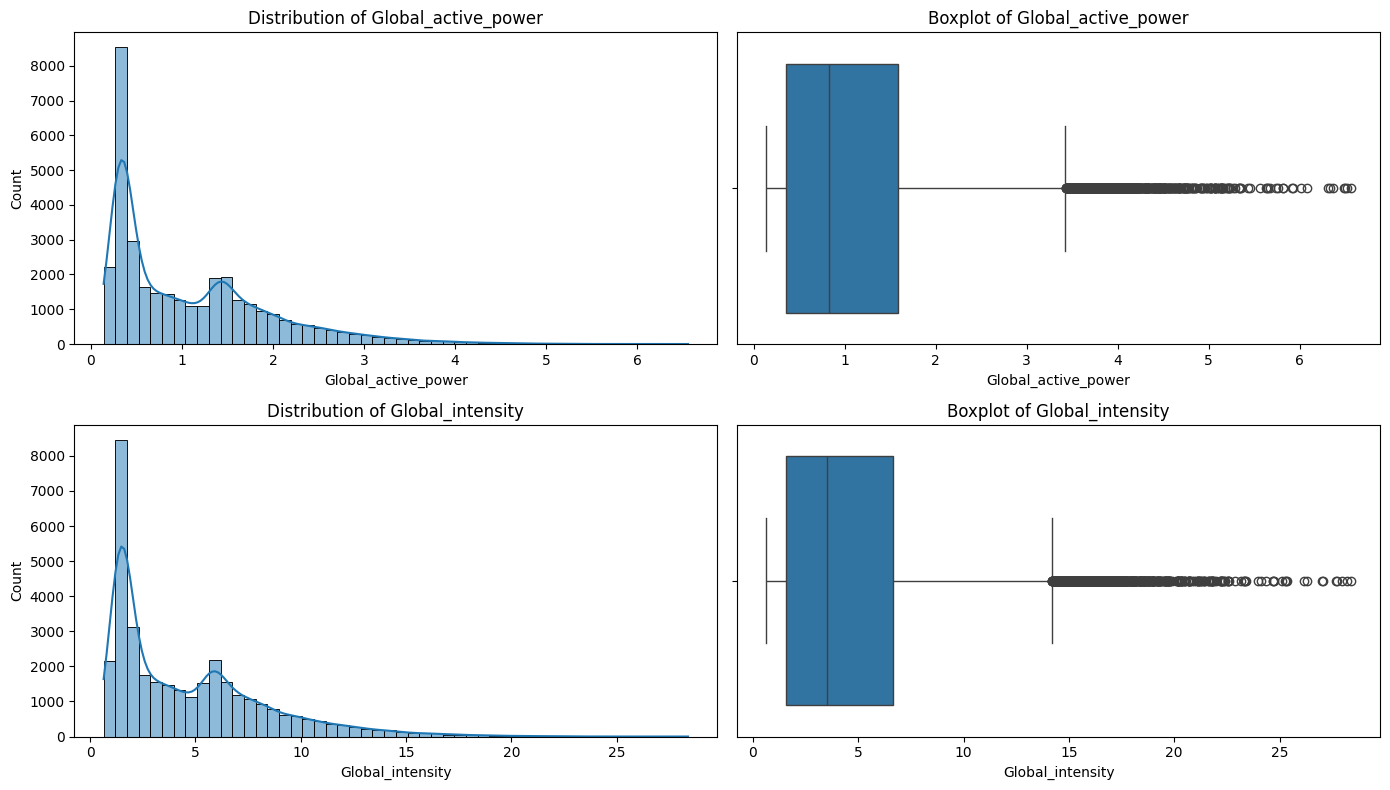

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

features = ["Global_active_power", "Global_intensity"]

for i, col in enumerate(features):
    sns.histplot(df[col], kde=True, bins=50, ax=axes[i,0])
    axes[i,0].set_title(f"Distribution of {col}")

    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

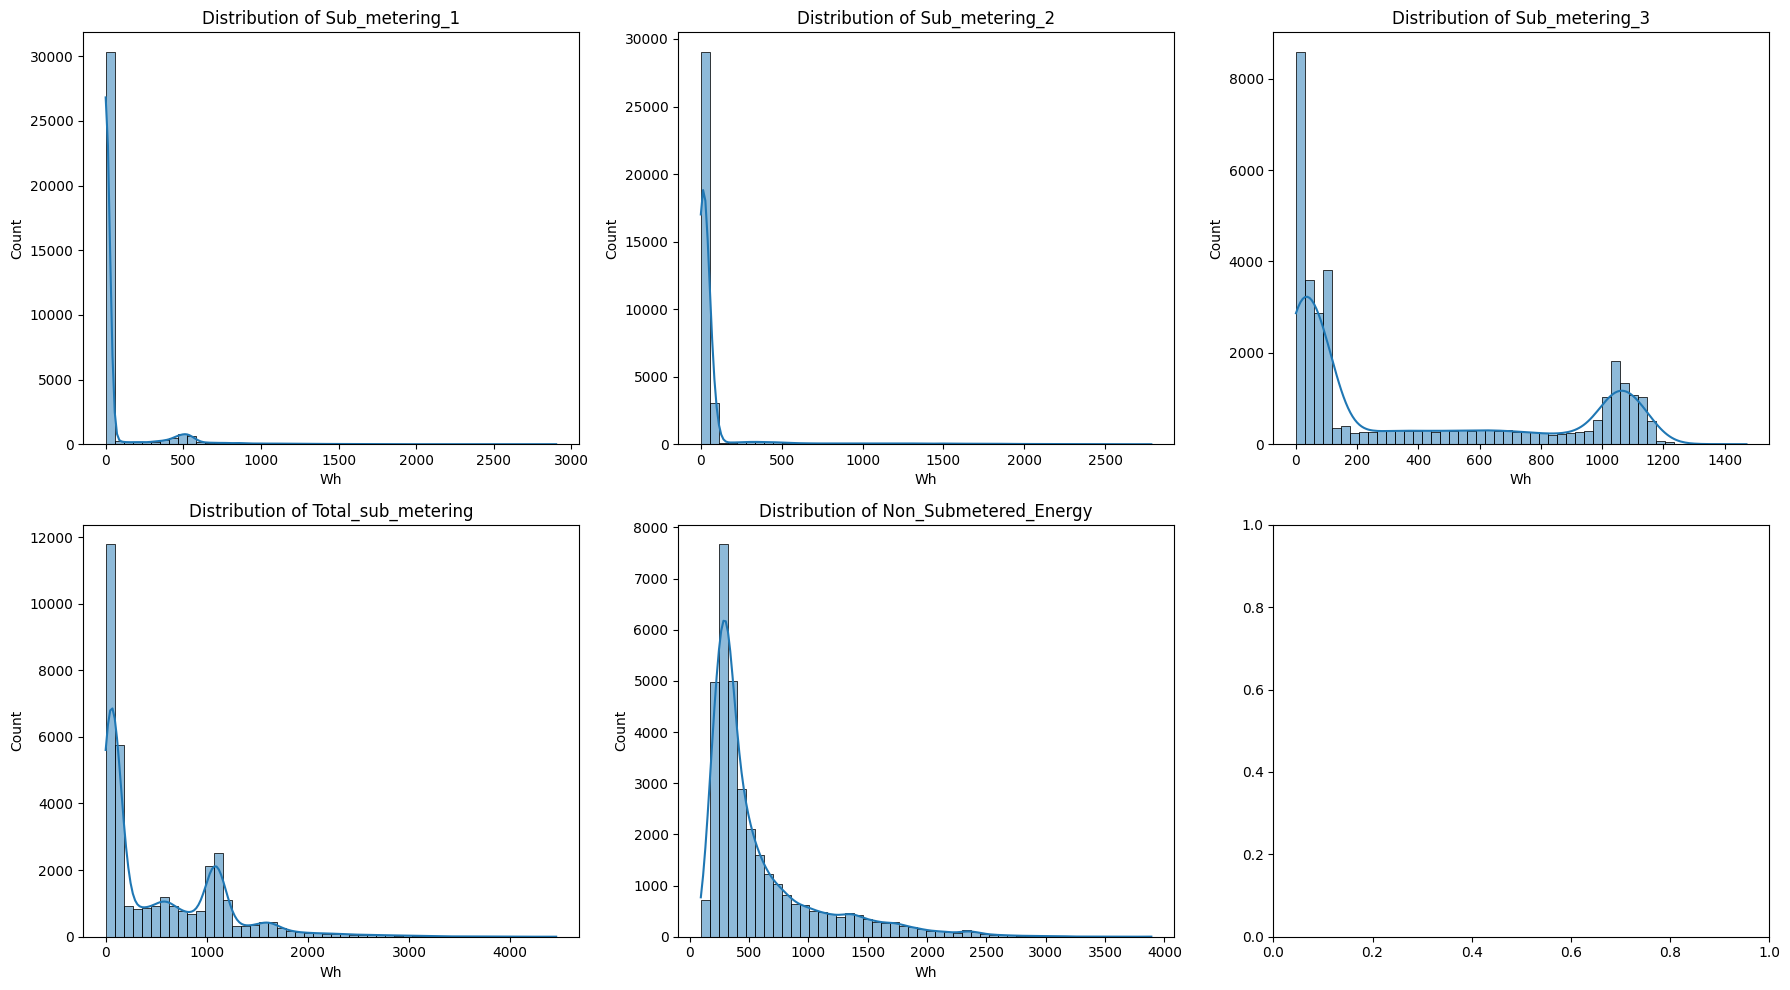

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sub_features = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3", "Total_sub_metering", "Non_Submetered_Energy"]

for i, col in enumerate(sub_features):
    row, colpos = divmod(i, 3)
    sns.histplot(df[col], kde=True, bins=50, ax=axes[row, colpos])
    axes[row, colpos].set_title(f"Distribution of {col}")
    axes[row, colpos].set_xlabel("Wh")
    axes[row, colpos].set_ylabel("Count")

plt.tight_layout()
plt.show()

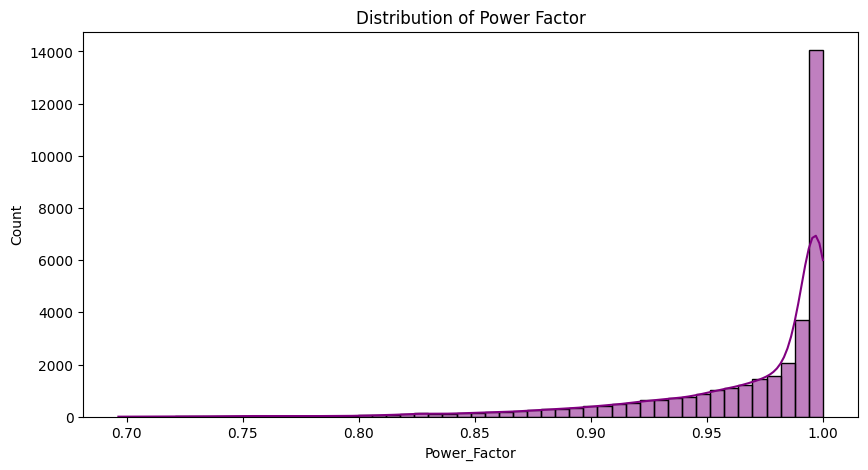

In [118]:
plt.figure(figsize=(10,5))
sns.histplot(df["Power_Factor"], kde=True, bins=50, color="purple")
plt.title("Distribution of Power Factor")
plt.show()

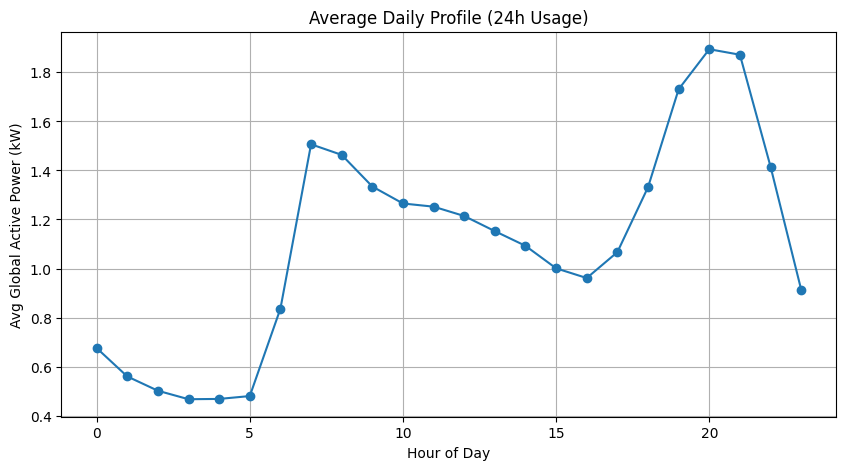

In [119]:
hourly_profile = df.groupby('hour')["Global_active_power"].mean()

plt.figure(figsize=(10,5))
hourly_profile.plot(kind='line', marker='o')
plt.title("Average Daily Profile (24h Usage)")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Global Active Power (kW)")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

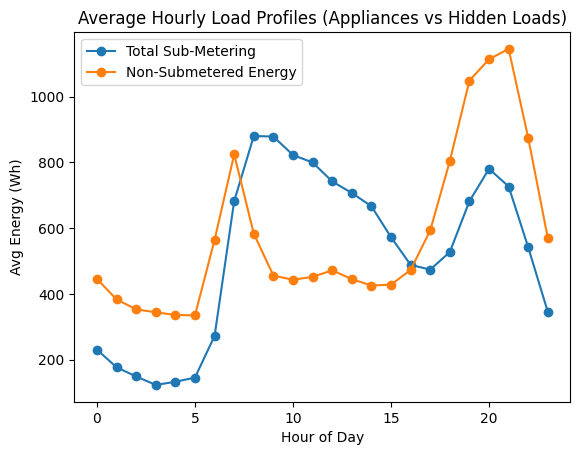

In [120]:
hourly_profile = df.groupby("hour")[["Total_sub_metering", "Non_Submetered_Energy"]].mean()

plt.figure(figsize=(10,6))
hourly_profile.plot(marker="o")
plt.title("Average Hourly Load Profiles (Appliances vs Hidden Loads)")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Energy (Wh)")
plt.legend(["Total Sub-Metering", "Non-Submetered Energy"])
plt.show()


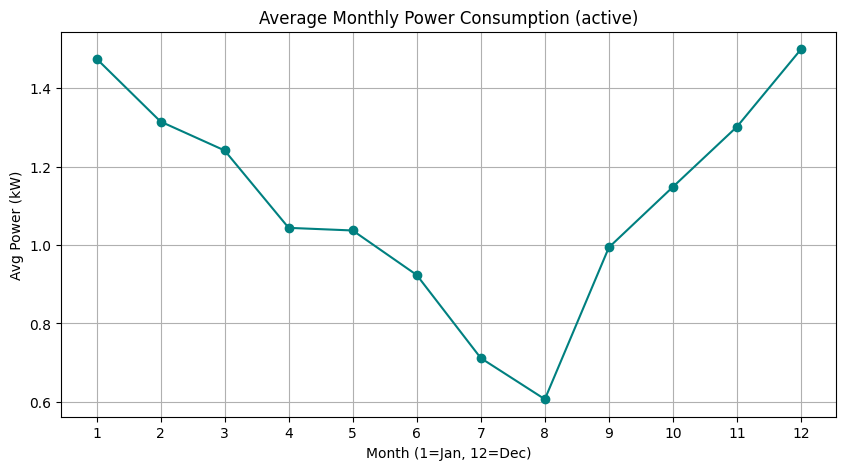

In [121]:
monthly_avg = df.groupby("month")["Global_active_power"].mean()

plt.figure(figsize=(10,5))
monthly_avg.plot(kind="line", marker="o", color="teal")
plt.title("Average Monthly Power Consumption (active)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Avg Power (kW)")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

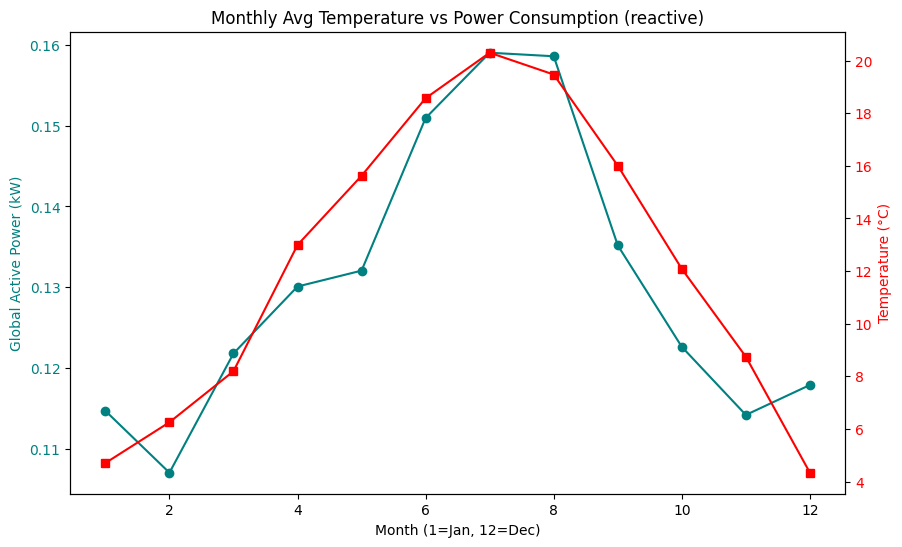

In [122]:
monthly_weather = df.groupby("month")[["Temperature_C", "Global_reactive_power"]].mean()

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(monthly_weather.index, monthly_weather["Global_reactive_power"], marker="o", color="teal", label="Reactive Power (kVAR)")
ax1.set_ylabel("Global Active Power (kW)", color="teal")
ax1.set_xlabel("Month (1=Jan, 12=Dec)")
ax1.tick_params(axis="y", labelcolor="teal")

ax2 = ax1.twinx()
ax2.plot(monthly_weather.index, monthly_weather["Temperature_C"], marker="s", color="red", label="Temperature (°C)")
ax2.set_ylabel("Temperature (°C)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Monthly Avg Temperature vs Power Consumption (reactive)")
plt.show()

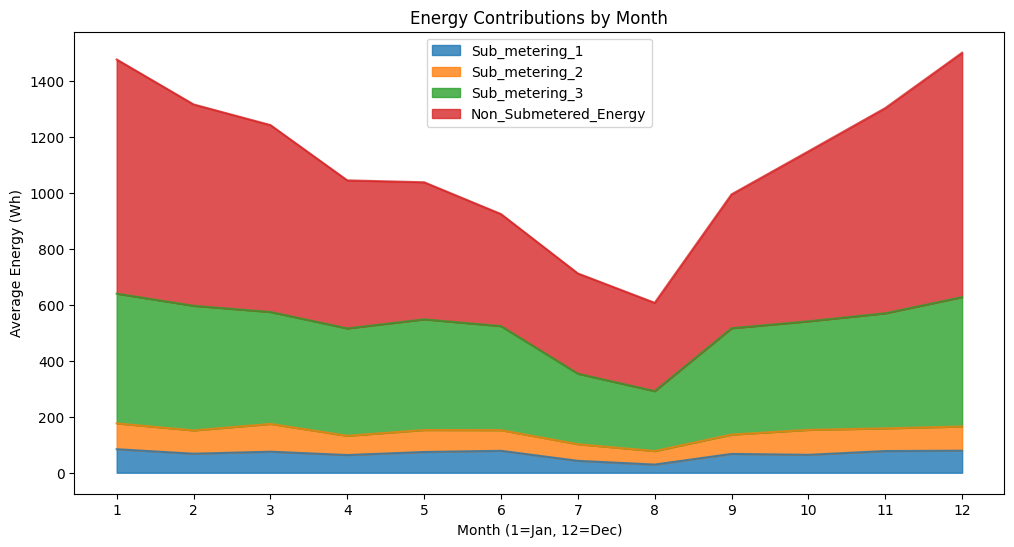

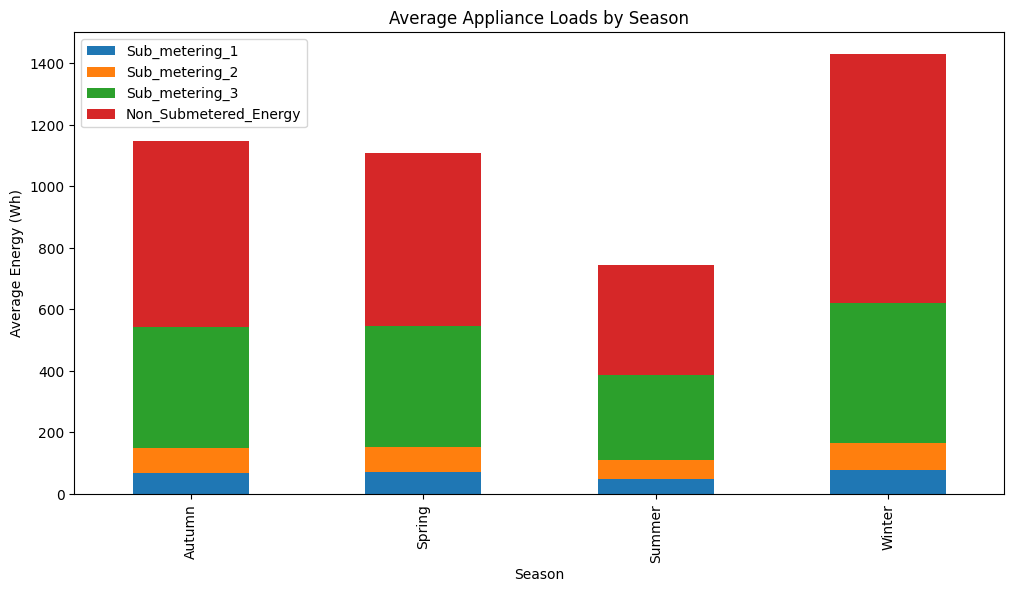

In [123]:
monthly_loads = df.groupby("month")[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3", "Non_Submetered_Energy"]].mean()

# Stacked area plot
monthly_loads.plot.area(figsize=(12,6), alpha=0.8)
plt.title("Energy Contributions by Month")
plt.ylabel("Average Energy (Wh)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.xticks(range(1,13))
plt.show()

season_energy = df.groupby("Season")[["Sub_metering_1","Sub_metering_2","Sub_metering_3","Non_Submetered_Energy"]].mean()

season_energy.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Average Appliance Loads by Season")
plt.ylabel("Average Energy (Wh)")
plt.xlabel("Season")
plt.show()

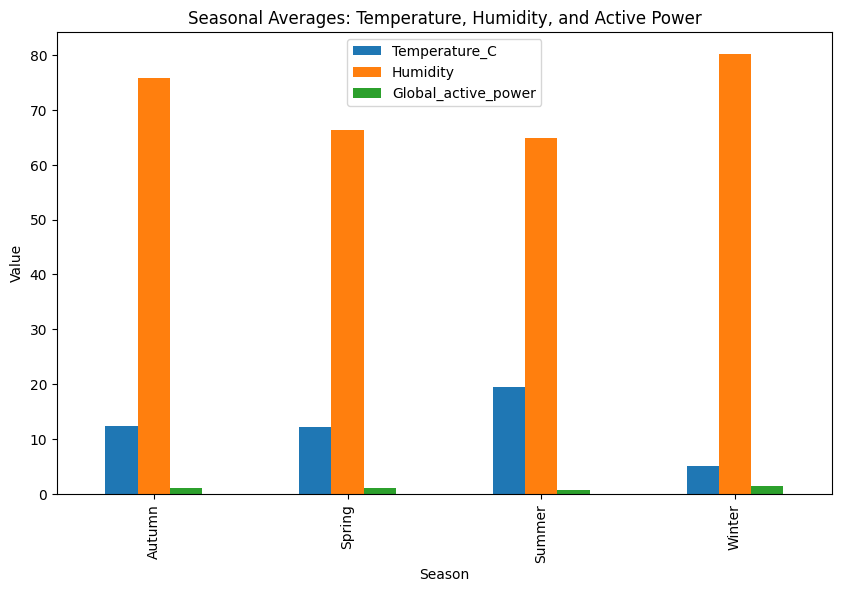

In [124]:
season_weather = df.groupby("Season")[["Temperature_C","Humidity","Global_active_power"]].mean()

season_weather.plot(kind="bar", figsize=(10,6))
plt.title("Seasonal Averages: Temperature, Humidity, and Active Power")
plt.ylabel("Value")
plt.show()


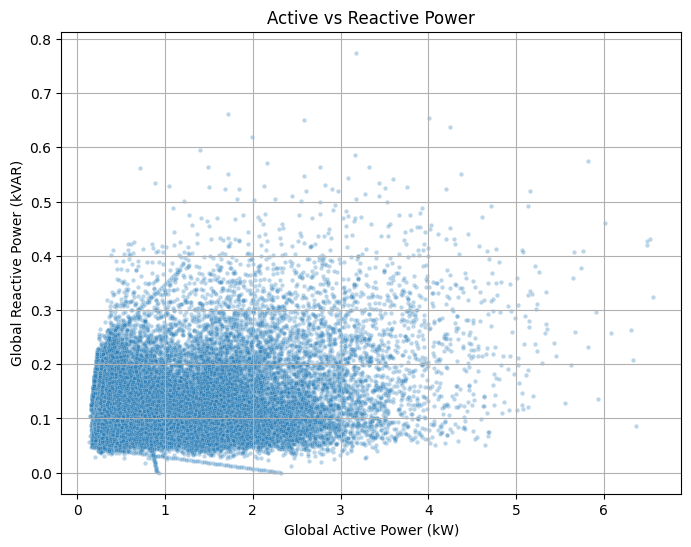

In [125]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Global_active_power", 
    y="Global_reactive_power", 
    data=df, alpha=0.3, s=10
)
plt.title("Active vs Reactive Power")
plt.xlabel("Global Active Power (kW)")
plt.ylabel("Global Reactive Power (kVAR)")
plt.grid(True)
plt.show()


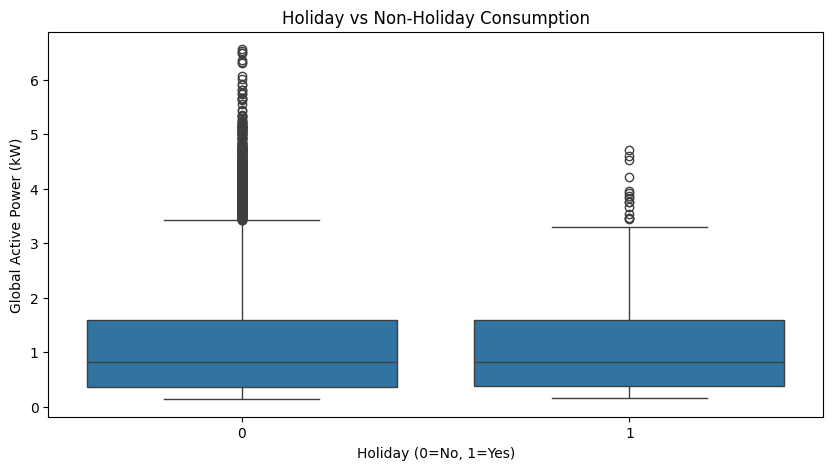

In [126]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["is_holiday"], y=df["Global_active_power"])
plt.title("Holiday vs Non-Holiday Consumption")
plt.xlabel("Holiday (0=No, 1=Yes)")
plt.ylabel("Global Active Power (kW)")
plt.show()

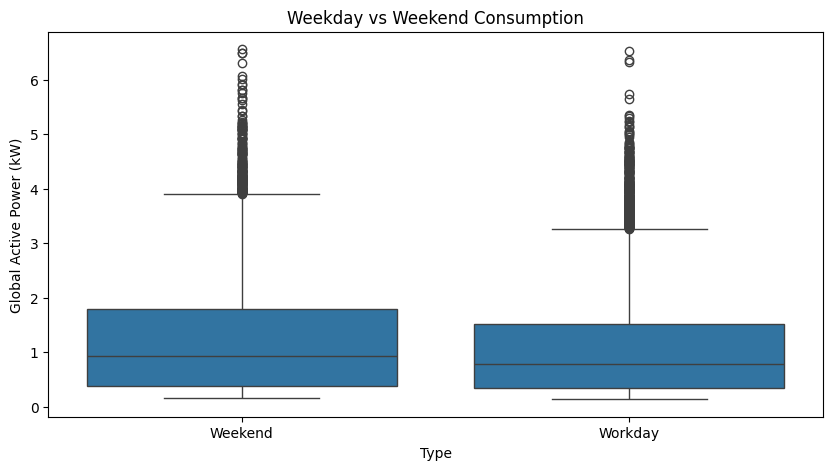

In [127]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["day_type"], y=df["Global_active_power"])
plt.title("Weekday vs Weekend Consumption")
plt.xlabel("Type")
plt.ylabel("Global Active Power (kW)")
plt.show()

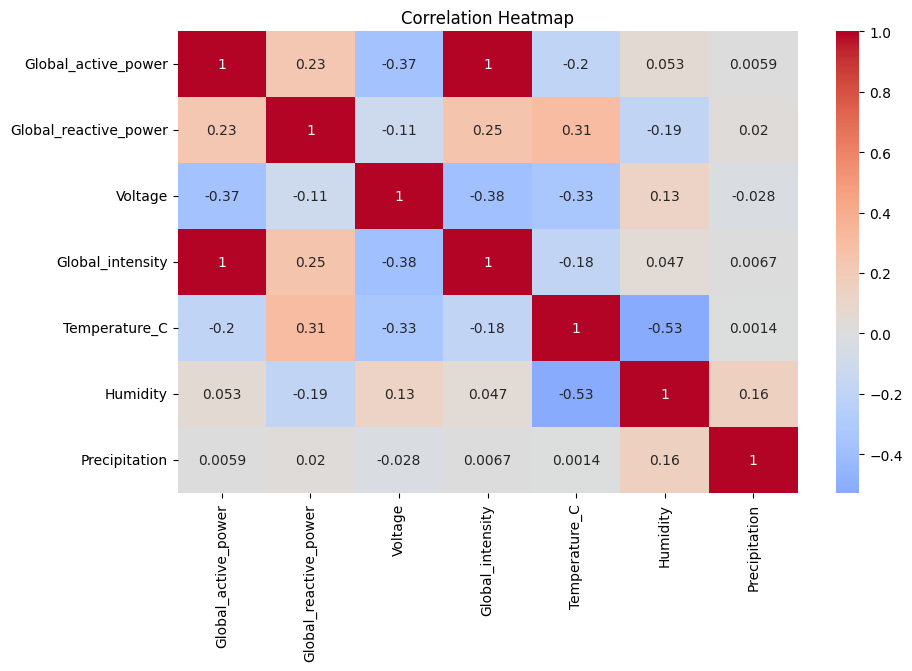

In [128]:
plt.figure(figsize=(10,6))
corr_features = ["Global_active_power", "Global_reactive_power", "Voltage","Global_intensity",
                 "Temperature_C","Humidity","Precipitation"]
sns.heatmap(df[corr_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

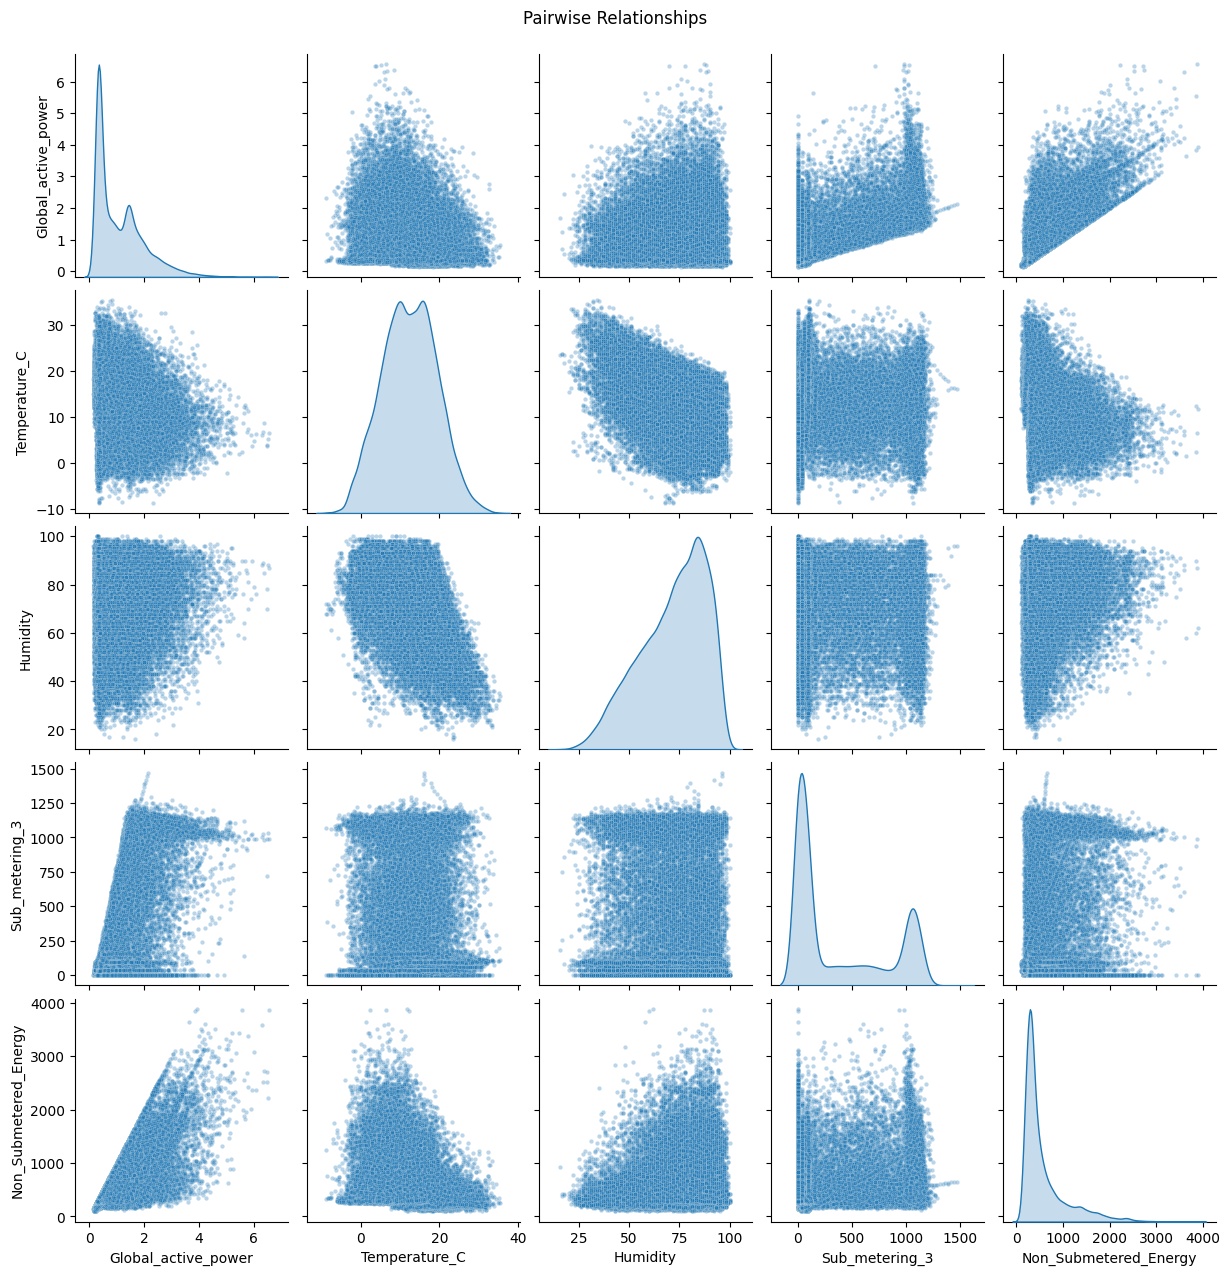

In [129]:
sns.pairplot(
    df[["Global_active_power", "Temperature_C", "Humidity", "Sub_metering_3", "Non_Submetered_Energy"]],
    diag_kind="kde",
    plot_kws={"alpha":0.3, "s":10}
)
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


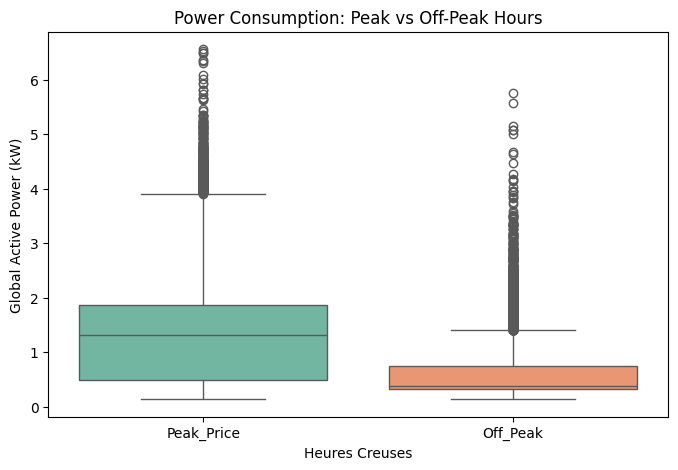

In [130]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Tariff_Zone", y="Global_active_power", data=df, palette="Set2")
plt.title("Power Consumption: Peak vs Off-Peak Hours")
plt.xlabel("Heures Creuses")
plt.ylabel("Global Active Power (kW)")
plt.show()

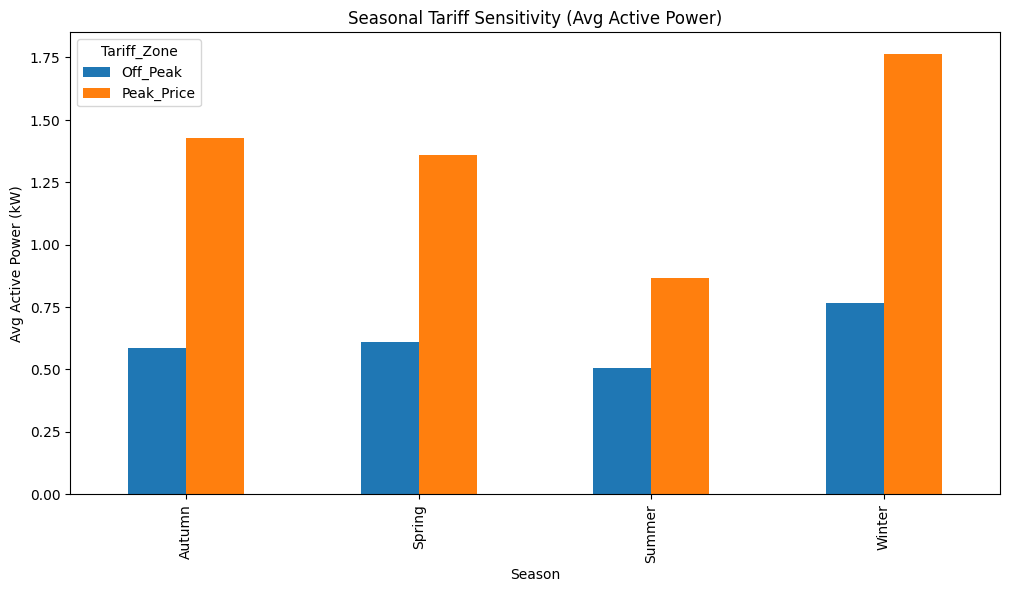

In [131]:
season_tariff = df.groupby(["Season","Tariff_Zone"])["Global_active_power"].mean().unstack()

season_tariff.plot(kind="bar", figsize=(12,6))
plt.title("Seasonal Tariff Sensitivity (Avg Active Power)")
plt.ylabel("Avg Active Power (kW)")
plt.xlabel("Season")
plt.show()

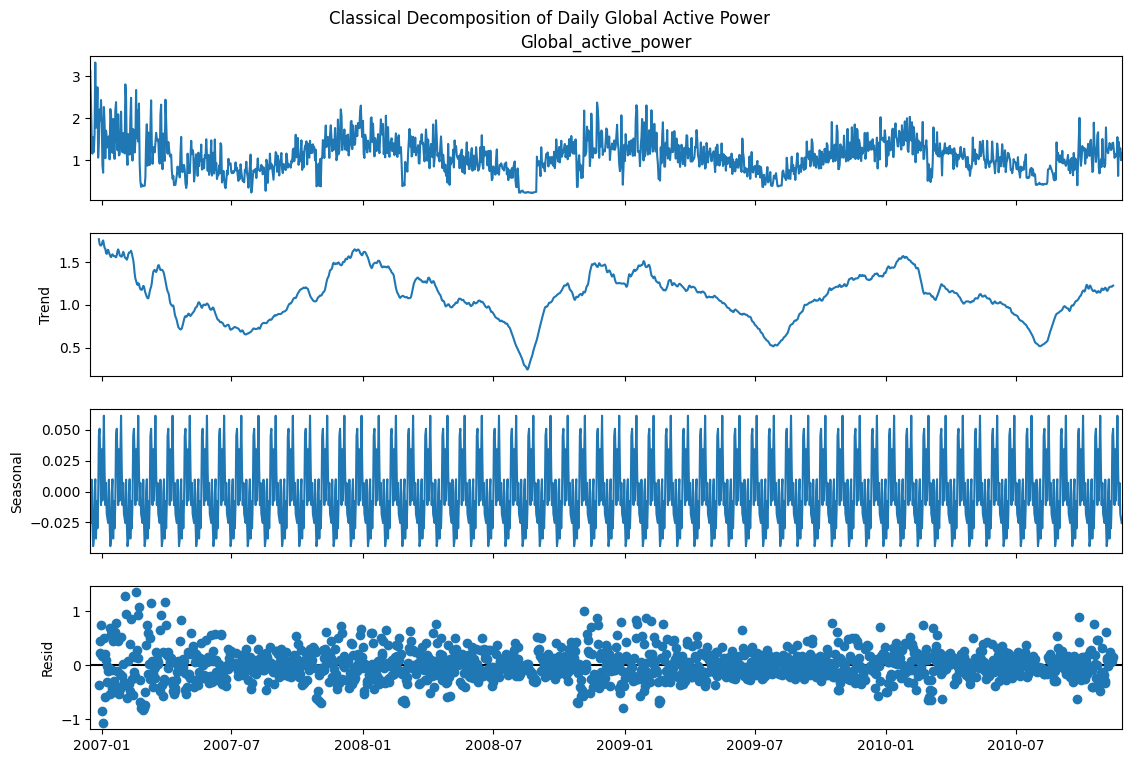

In [132]:
daily_series = df["Global_active_power"].resample("D").mean()

result = seasonal_decompose(daily_series, model="additive", period=24)

fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Classical Decomposition of Daily Global Active Power")
plt.show()

# Time series modeling

In [133]:
df[df['Global_active_power'].isnull()]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Temperature_C,Humidity,...,solar_radiation,Season,is_Day_Before_Holiday,is_Day_After_Holiday,Heures_Creuses,Tariff_Zone,Non_Submetered_Energy,Temp_Regime,Power_Factor,HICP_Energy_Index
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-10-06 11:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,17.0,72.0,...,337.98,Autumn,0,0,0,Peak_Price,NaN,Mild_Passive,NaN,83.26
2008-10-06 12:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,17.8,71.0,...,297.35,Autumn,0,0,0,Peak_Price,NaN,Mild_Passive,NaN,83.26
2008-10-06 13:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,18.0,64.0,...,229.50,Autumn,0,0,0,Peak_Price,NaN,Mild_Passive,NaN,83.26
2008-10-06 14:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,17.0,68.0,...,185.30,Autumn,0,0,0,Peak_Price,NaN,Mild_Passive,NaN,83.26
2008-10-06 15:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,17.0,69.0,...,117.35,Autumn,0,0,0,Peak_Price,NaN,Mild_Passive,NaN,83.26


In [134]:
null_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
             'Global_intensity', 'Non_Submetered_Energy', 'Power_Factor']

for col in null_cols:
    # ffill (fill from previous time step)
    df[col] = df[col].ffill()

In [135]:
Data = df['Global_active_power']
Data

Datetime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
                         ...   
2010-11-26 17:00:00    1.717448
2010-11-26 18:00:00    1.573467
2010-11-26 19:00:00    1.659333
2010-11-26 20:00:00    1.163700
2010-11-26 21:00:00    0.934667
Name: Global_active_power, Length: 34589, dtype: float64

In [136]:
def eval(test_data, forecast):
    mse  = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(test_data, forecast)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

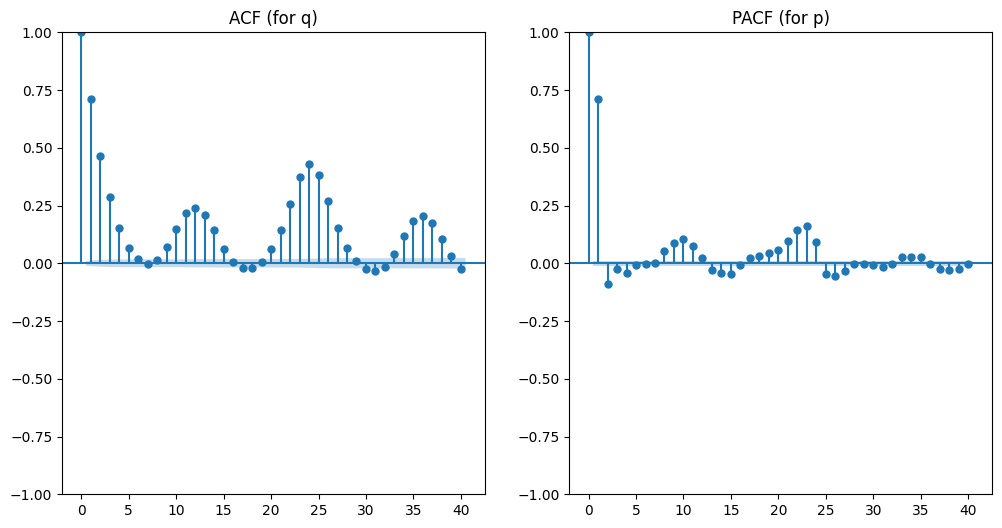

In [137]:
train = Data.iloc[:-2160]
test = Data.iloc[-2160:]

plt.figure(figsize=(12,6))

# ACF Plot (for q)
plt.subplot(121)
plot_acf(Data, lags=40, ax=plt.gca())
plt.title('ACF (for q)')

# PACF Plot (for p)
plt.subplot(122)
plot_pacf(Data, lags=40, ax=plt.gca())
plt.title('PACF (for p)')

plt.show()

In [138]:
adf_result = adfuller(Data)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -14.443889257236185
p-value: 7.283351798176985e-27


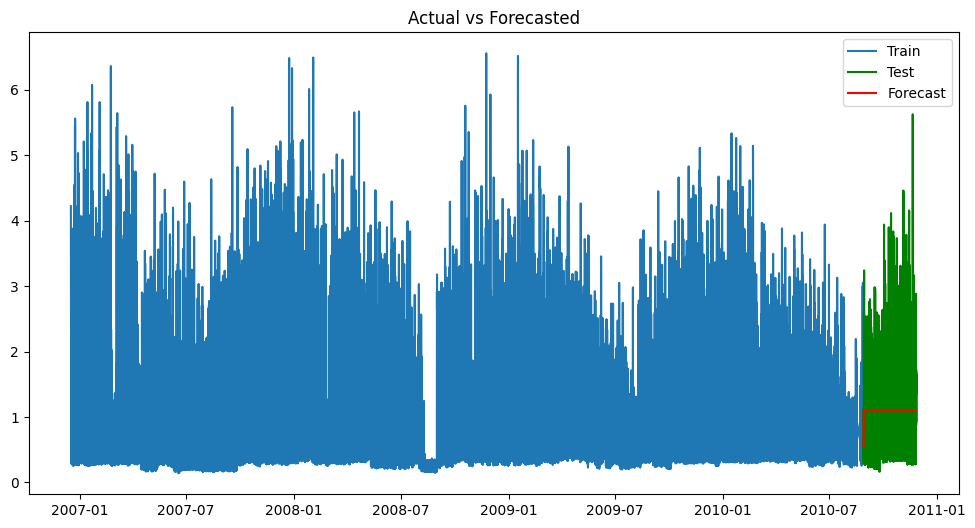

{'MSE': 0.5978817001316692,
 'RMSE': np.float64(0.77322810355785),
 'MAE': 0.6355153417033276}

In [139]:
model = ARIMA(train, order=(1, 0, 1))
fitted_model = model.fit()

forecast = fitted_model.forecast(len(test))
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Actual vs Forecasted')
plt.show()
eval(test, forecast)

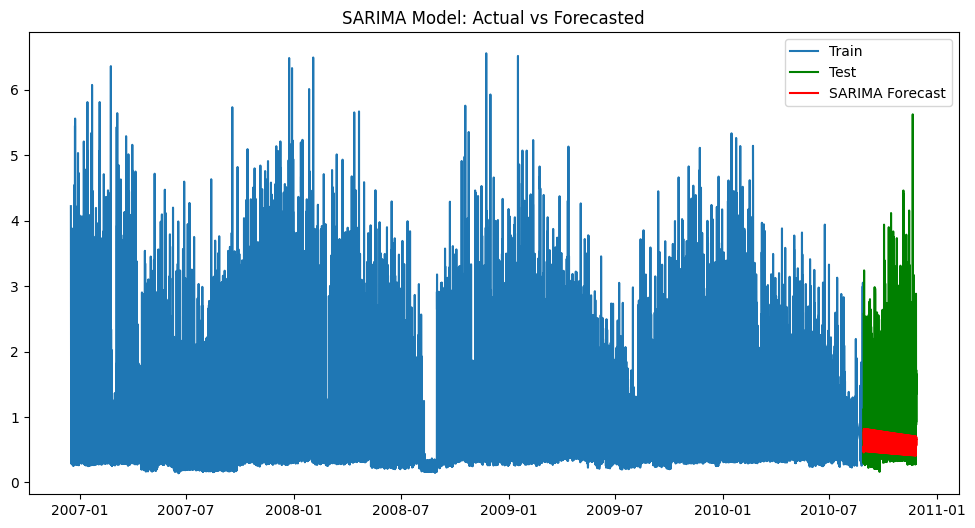

{'MSE': 0.7950271375966951,
 'RMSE': np.float64(0.8916429428850402),
 'MAE': 0.6335735359424501}

In [140]:
sarima_model = SARIMAX(train,
                       order=(1,0,1),
                       seasonal_order=(1,0,1,24))

sarima_fitted = sarima_model.fit()

# Forecast
sarima_forecast = sarima_fitted.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.legend()
plt.title('SARIMA Model: Actual vs Forecasted')
plt.show()
eval(test, sarima_forecast)

18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing


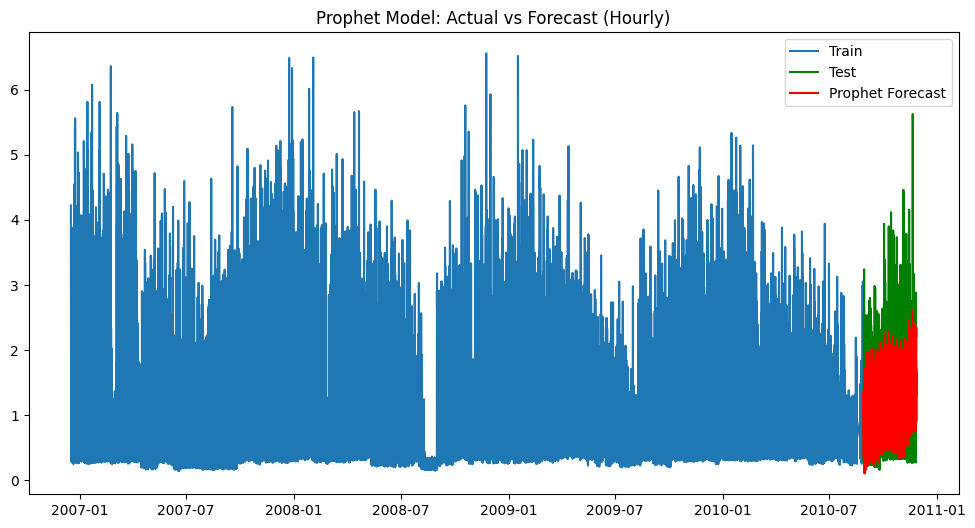

{'MSE': 0.44305845815703004,
 'RMSE': np.float64(0.6656263652808759),
 'MAE': 0.5118606053524569}

In [157]:
train_df = train.reset_index()
train_df.columns = ['ds', 'y']

# Fit Prophet on train
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.1)
model.add_seasonality(name='hourly', period=24, fourier_order=10)
model.fit(train_df)

# Future = test horizon
future = pd.DataFrame({'ds': test.index})
forecast = model.predict(future)
forecast_test = forecast.set_index('ds')['yhat']

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(forecast_test.index, forecast_test, label='Prophet Forecast', color='red')
plt.legend()
plt.title('Prophet Model: Actual vs Forecast (Hourly)')
plt.show()
eval(test, forecast_test)

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler

target_col = 'Global_active_power'

feature_cols = ['hour_sin','hour_cos','dow_sin','dow_cos','month_sin','month_cos', 'day_of_week', 'month',
                'is_holiday','Heures_Creuses','Temperature_C','Humidity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3']
X_cols = feature_cols + [target_col]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[X_cols].values)
y_scaled = scaler_y.fit_transform(df[[target_col]].values).ravel()

def create_sequences(X, y, t):
    Xs, ys = [], []
    for i in range(t, len(X)):
        Xs.append(X[i-t:i, :])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 24
X, y = create_sequences(X_scaled, y_scaled, time_steps)

X_train, X_test = X[:-2160], X[-2160:]
y_train, y_test = y[:-2160], y[-2160:]

model = Sequential()
model.add(LSTM(units=120, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es])

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))



Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0137 - val_loss: 0.0056
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0086 - val_loss: 0.0049
Epoch 4/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 5/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0080 - val_loss: 0.0047
Epoch 6/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 7/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0077 - val_loss: 0.0046
Epoch 8/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0076 - val_loss: 0.0045
Epoch 9/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 10/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 11/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 12/100
912/912 ━━━━━━━━

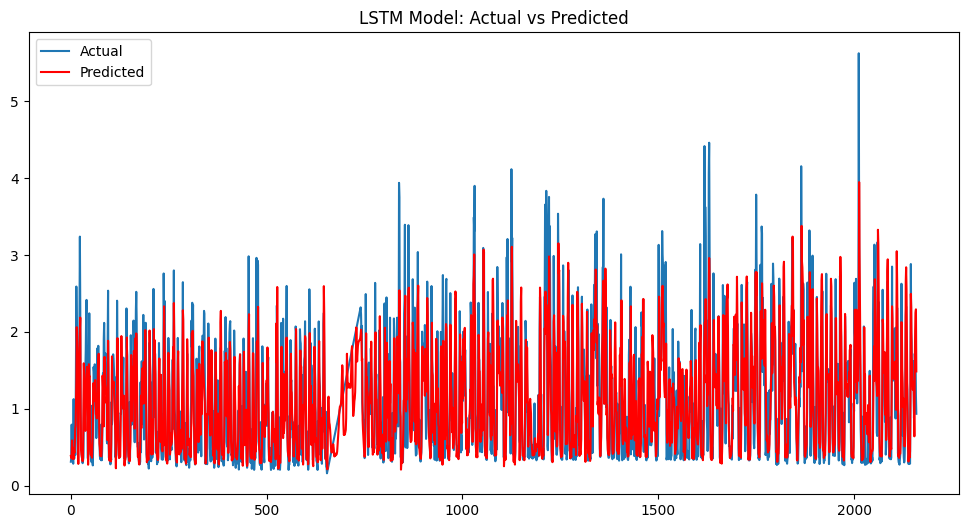

LSTM MSE: 0.245434130482037
LSTM RMSE: 0.49541309074552825
LSTM MAE: 0.35106089919954286


In [161]:
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Actual')
plt.plot(y_pred, label='Predicted', color='red')
plt.legend()
plt.title('LSTM Model: Actual vs Predicted')
plt.show()

# Evaluation metrics
lstm_mse = mean_squared_error(y_test_real, y_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_real, y_pred)

print('LSTM MSE:', lstm_mse)
print('LSTM RMSE:', lstm_rmse)
print('LSTM MAE:', lstm_mae)
